Calculate the Bayes Factor for the absolute magnitude to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import dynesty
from dynesty import plotting as dyplot

import matplotlib
import matplotlib.pyplot as plt

from functions import Model_1_fit, Model_2_fit, Model_1_plot, Model_2_plot, Model_1_sampler, Model_2_sampler, uniform, jeffreys

#from scipy import stats
#from scipy.optimize import curve_fit
#from scipy.stats import skewnorm

np.set_printoptions(threshold=sys.maxsize)

In [2]:
#matplotlib.rcParams['text.usetex']=True
matplotlib.rc('font', size=14)
#matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4])

## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

# Fit the distributions with skewnormal distributions

Both one- and two-parent models

## $M_r$

This is a unimodal distribution

### 1-parent model

In [8]:
rabsmag_fit_bounds1 = [[0.1, 10],     # s ...... Gaussian 1 to 2 scale factor
                       [1000, 20000], # a ...... Gaussian amplitude
                       [-22, -18],    # mu ..... Gaussian location
                       [0.1, 3],      # sigma .. Gaussian scale
                       [0, 5]]        # skew ... Gaussian skew

rabsmag_bins = np.linspace(-25, -12.5, 170)

V2_rabsmag_bestfit1 = Model_1_fit(rabsmag_fit_bounds1, 
                                  rabsmag_NSA[wall_v2], 
                                  rabsmag_NSA[void_v2], 
                                  rabsmag_bins, 
                                  1)

VF_rabsmag_bestfit1 = Model_1_fit(rabsmag_fit_bounds1, 
                                  rabsmag_NSA[wall_vf], 
                                  rabsmag_NSA[void_vf], 
                                  rabsmag_bins, 
                                  1)

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [9]:
V2_rabsmag_bestfit1

      fun: 13761.64724400627
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.29776857, -0.00272851, -0.61827445, -0.45838533,  0.02855813])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 354
      nit: 46
     njev: 59
   status: 0
  success: True
        x: array([ 2.28131808e+00,  7.94872507e+03, -2.11770843e+01,  1.83442427e+00,
        2.69809518e+00])

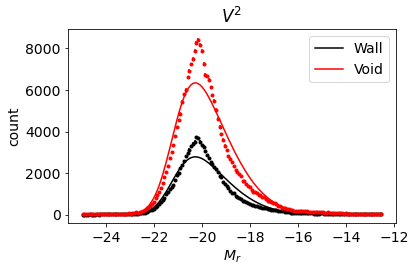

In [10]:
Model_1_plot(V2_rabsmag_bestfit1.x, 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             1, 
             xlabel_text='$M_r$', 
             title_text='$V^2$')

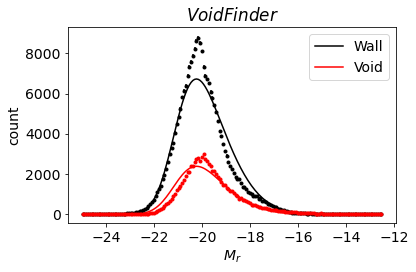

In [11]:
Model_1_plot(VF_rabsmag_bestfit1.x, 
             rabsmag_NSA[wall_vf], 
             rabsmag_NSA[void_vf], 
             rabsmag_bins, 
             1, 
             xlabel_text='$M_r$', 
             title_text='$VoidFinder$')

In [12]:
VF_rabsmag_bestfit1

      fun: 11986.11352410794
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.05810614,  0.00636595, -0.2874003 , -0.9797077 ,  0.07603376])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 372
      nit: 41
     njev: 62
   status: 0
  success: True
        x: array([ 3.55629273e-01,  1.80260920e+04, -2.10809218e+01,  1.65330285e+00,
        2.30242254e+00])

#### Nested sampling of Likelihood and Priors

In [29]:
def prior_xform1_uni_V2(u):
    '''
    Priors for the 5 parameters of unimodel M1 for V2.  Required by 
    the dynesty sampler.  Note that this is customized for the 
    absolute magnitude fitting.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.1, 5, u[0])
    a = jeffreys(1000, 100000, u[1])
    mu = uniform(-24, -18, u[2])
    sigma = uniform(0.01, 5, u[3])
    skew = uniform(0, 5, u[4])

    return s, a, mu, sigma, skew

In [30]:
Model_1_sampler(prior_xform1_uni_V2, 
                rabsmag_NSA[wall_v2], 
                rabsmag_NSA[void_v2], 
                rabsmag_bins, 
                1, 
                '_rabsmag_V2')

running the nested sampler... this might take from minutes to hours...


34454it [04:18, 133.43it/s, batch: 9 | bound: 111 | nc: 2 | ncall: 97555 | eff(%): 35.318 | loglstar: -13769.030 < -13761.693 < -13762.908 | logz: -13792.975 +/-  0.333 | stop:  0.923]       

sampler output saved as pickle file 'dynesty_output/sampler_results_model1_rabsmag_V2'


In [31]:
temp_infile = open('dynesty_output/sampler_results_model1_rabsmag_V2.pickle', 'rb')
dres1_V2_rabsmag = pickle.load(temp_infile)
temp_infile.close()

In [32]:
labels1_uni = ['s', 'a', r'$\mu$', r'$\sigma$', 'skew']
labels2_uni = ['a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']

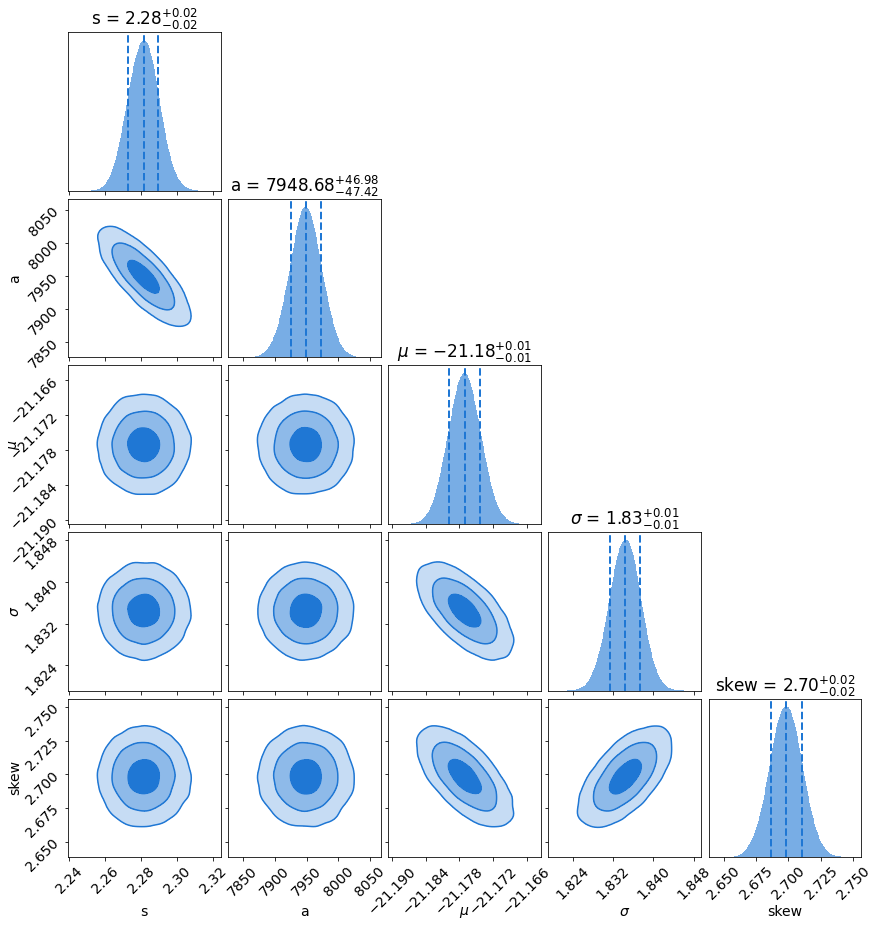

In [33]:
fig, axes = dyplot.cornerplot(dres1_V2_rabsmag, smooth=0.03, 
                              labels=labels1_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(5, 5, figsize=(2.5*5, 2.6*5)), 
                              color='#1f77d4')

In [34]:
lnzM1_V2_rabsmag = dres1_V2_rabsmag.logz[-1]
lnzM1_V2_rabsmag

-13792.988999905096

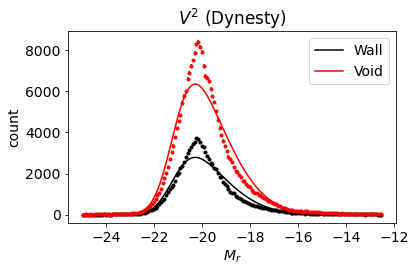

In [35]:
Model_1_plot([2.28, 7948.68, -21.18, 1.83, 2.70], 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             1, 
             xlabel_text='$M_r$', 
             title_text='$V^2$ (Dynesty)')

In [36]:
def prior_xform1_uni_VF(u):
    '''
    Priors for the 5 parameters of unimodel M1 for VoidFinder.  Required 
    by the dynesty sampler.  Note that this is customized for the 
    absolute magnitude fitting.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.01, 5, u[0])
    a = jeffreys(1000, 100000, u[1])
    mu = uniform(-24, -18, u[2])
    sigma = uniform(0.01, 5, u[3])
    skew = uniform(0, 5, u[4])

    return s, a, mu, sigma, skew

In [37]:
Model_1_sampler(prior_xform1_uni_VF, 
                rabsmag_NSA[wall_vf], 
                rabsmag_NSA[void_vf], 
                rabsmag_bins, 
                1, 
                '_rabsmag_VoidFinder')

running the nested sampler... this might take from minutes to hours...


35549it [05:05, 116.23it/s, batch: 9 | bound: 110 | nc: 1 | ncall: 98203 | eff(%): 36.200 | loglstar: -11993.580 < -11986.184 < -11987.238 | logz: -12019.443 +/-  0.345 | stop:  0.869]      

sampler output saved as pickle file 'dynesty_output/sampler_results_model1_rabsmag_VoidFinder'


In [36]:
temp_infile = open('dynesty_output/sampler_results_model1_rabsmag_VoidFinder.pickle', 'rb')
dres1_VF_rabsmag = pickle.load(temp_infile)
temp_infile.close()

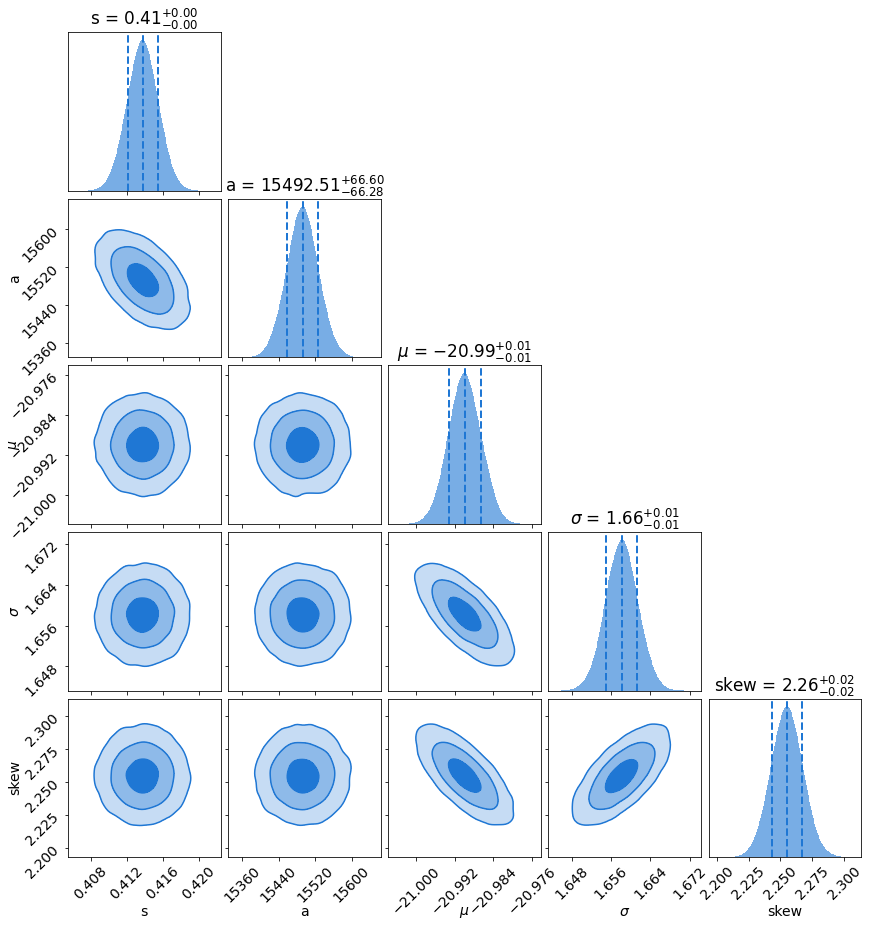

In [37]:
fig, axes = dyplot.cornerplot(dres1_VF_rabsmag, smooth=0.03, 
                              labels=labels1_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(5, 5, figsize=(2.5*5, 2.6*5)), 
                              color='#1f77d4')

In [38]:
lnzM1_VF_rabsmag = dres1_VF_rabsmag.logz[-1]
lnzM1_VF_rabsmag

-9042.176356648368

### 2-parent model

In [50]:
rabsmag_fit_bounds2 = [[500, 100000], # a ........ Gaussian A amplitude
                     [-25, -15],     # mu_a ..... Gaussian A location
                     [0.1, 5],       # sigma_a .. Gaussian A scale
                     [-5, 5],        # skew_a ... Gaussian A skew
                     [500, 10000],   # b ........ Gaussian B amplitude
                     [-25, -15],     # mu_b ..... Gaussian B location
                     [0.1, 3],       # sigma_b .. Gaussian B scale
                     [-5, 5]]        # skew_b ... Gaussian B skew

V2_rabsmag_bestfit2 = Model_2_fit(rabsmag_fit_bounds2, 
                                  rabsmag_NSA[wall_v2], 
                                  rabsmag_NSA[void_v2], 
                                  rabsmag_bins, 
                                  1)

VF_rabsmag_bestfit2 = Model_2_fit(rabsmag_fit_bounds2, 
                                  rabsmag_NSA[wall_vf], 
                                  rabsmag_NSA[void_vf], 
                                  rabsmag_bins, 
                                  1)

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [51]:
V2_rabsmag_bestfit2

      fun: 7875.0016788178
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.45702592e-04, -1.28966338e-01, -2.61934476e-02,  8.14907258e-02,
        3.72862859e-03, -2.93766764e-02,  6.08270060e-01,  8.84028855e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 927
      nit: 79
     njev: 103
   status: 0
  success: True
        x: array([ 4.66668817e+03, -2.15012465e+01,  1.83753361e+00,  2.87024539e+00,
        8.94774774e+03, -2.15178072e+01,  1.86753957e+00,  2.94201671e+00])

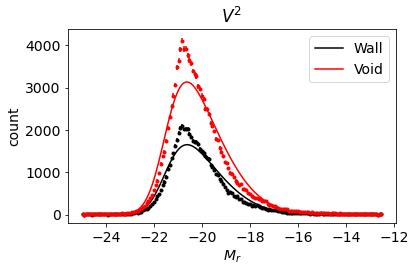

In [52]:
Model_2_plot(V2_rabsmag_bestfit2.x, 
             rabsmag_NSA[wall_v2], 
             rabsmag_NSA[void_v2], 
             rabsmag_bins, 
             1, 
             xlabel_text='$M_r$', 
             title_text='$V^2$')

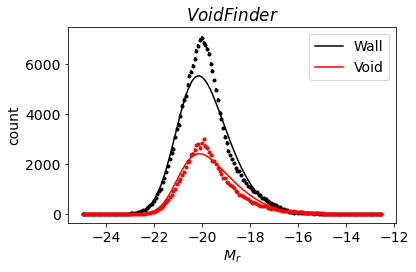

In [53]:
Model_2_plot(VF_rabsmag_bestfit2.x, 
             rabsmag_NSA[wall_vf], 
             rabsmag_NSA[void_vf], 
             rabsmag_bins, 
             1, 
             xlabel_text='$M_r$', 
             title_text='$VoidFinder$')

In [54]:
VF_rabsmag_bestfit2

      fun: 7739.287755346973
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.74145144, -0.3135028 ,  0.842374  , -0.33578545,  0.72378354,
       -0.08276401, -0.46857167,  0.06384653])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 648
      nit: 60
     njev: 72
   status: 0
  success: True
        x: array([ 1.46897185e+04, -2.09710357e+01,  1.57090995e+00,  1.99364169e+00,
        6.77316641e+03, -2.09863599e+01,  1.82171843e+00,  2.90871420e+00])

#### Nested sampling of Likelihood and Priors

In [57]:
def prior_xform2_uni(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a = jeffreys(500, 100000, u[0])
    mu_a = uniform(-25, -15, u[1])
    sigma_a = uniform(0.1, 5, u[2])
    skew_a = uniform(-5, 5, u[3])

    b = jeffreys(500, 10000, u[4])
    mu_b = uniform(-25, -15, u[5])
    sigma_b = uniform(0.1, 3, u[6])
    skew_b = uniform(-5, 5, u[7])

    return a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [58]:
Model_2_sampler(prior_xform2_uni, 
                rabsmag_NSA[wall_v2], 
                rabsmag_NSA[void_v2], 
                rabsmag_bins, 
                1, 
                '_rabsmag_V2')

running the nested sampler... this might take from minutes to hours...


38874it [05:28, 118.46it/s, batch: 7 | bound: 177 | nc: 1 | ncall: 151534 | eff(%): 25.654 | loglstar: -7883.693 < -7875.270 < -7876.966 | logz: -7922.190 +/-  0.409 | stop:  0.928]         

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_rabsmag_V2'


In [60]:
temp_infile = open('dynesty_output/sampler_results_model2_rabsmag_V2.pickle', 'rb')
dres2_V2_rabsmag = pickle.load(temp_infile)
temp_infile.close()

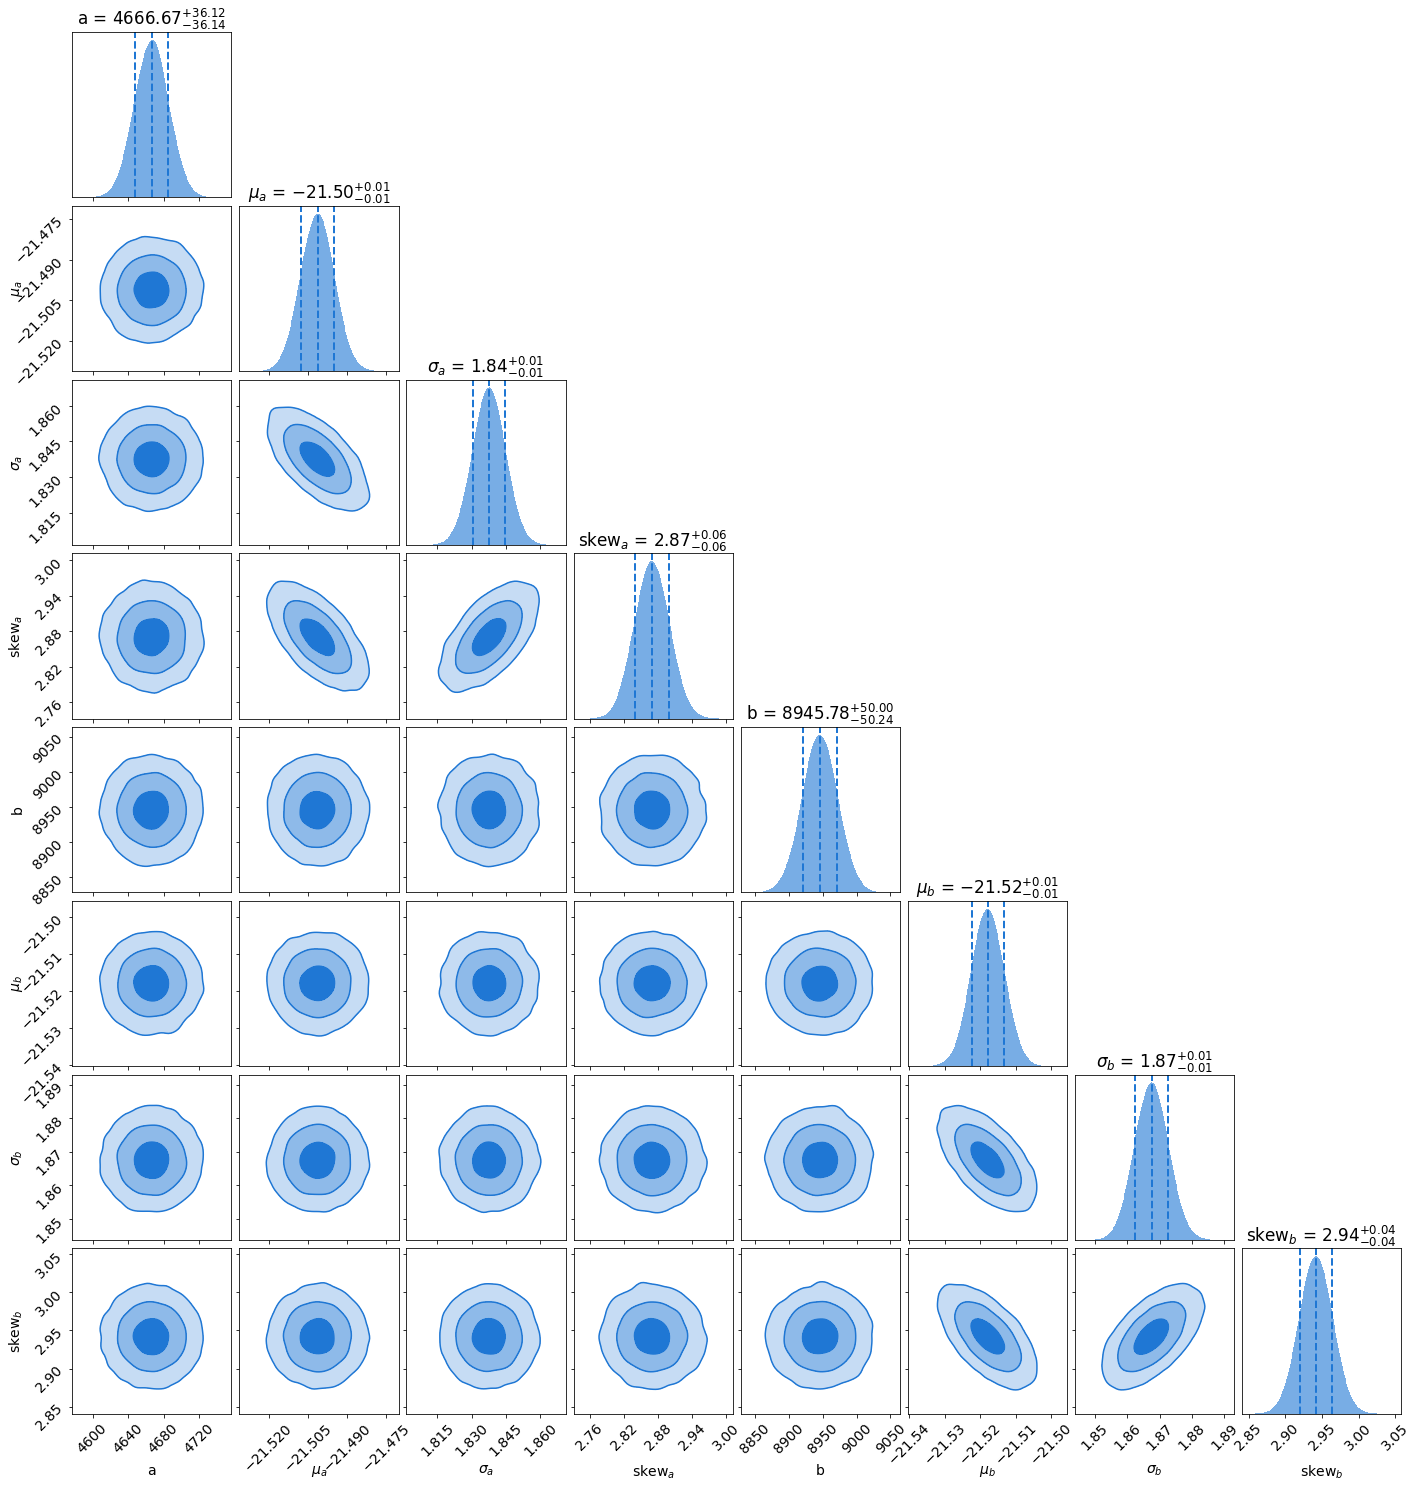

In [61]:
fig, axes = dyplot.cornerplot(dres2_V2_rabsmag, smooth=0.03, 
                              labels=labels2_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

In [62]:
lnzM2_V2_rabsmag = dres2_V2_rabsmag.logz[-1]
lnzM2_V2_rabsmag

-7922.214566965955

In [63]:
Model_2_sampler(prior_xform2_uni, 
                rabsmag_NSA[wall_vf], 
                rabsmag_NSA[void_vf], 
                rabsmag_bins, 
                1, 
                '_rabsmag_VoidFinder')

running the nested sampler... this might take from minutes to hours...


37391it [05:10, 120.29it/s, batch: 6 | bound: 230 | nc: 1 | ncall: 198158 | eff(%): 18.869 | loglstar: -7322.640 < -7314.527 < -7316.693 | logz: -7362.935 +/-  0.417 | stop:  0.928]         


sampler output saved as pickle file 'dynesty_output/sampler_results_model2_rabsmag_VoidFinder'


In [64]:
temp_infile = open('dynesty_output/sampler_results_model2_rabsmag_VoidFinder.pickle', 'rb')
dres2_VF_rabsmag = pickle.load(temp_infile)
temp_infile.close()

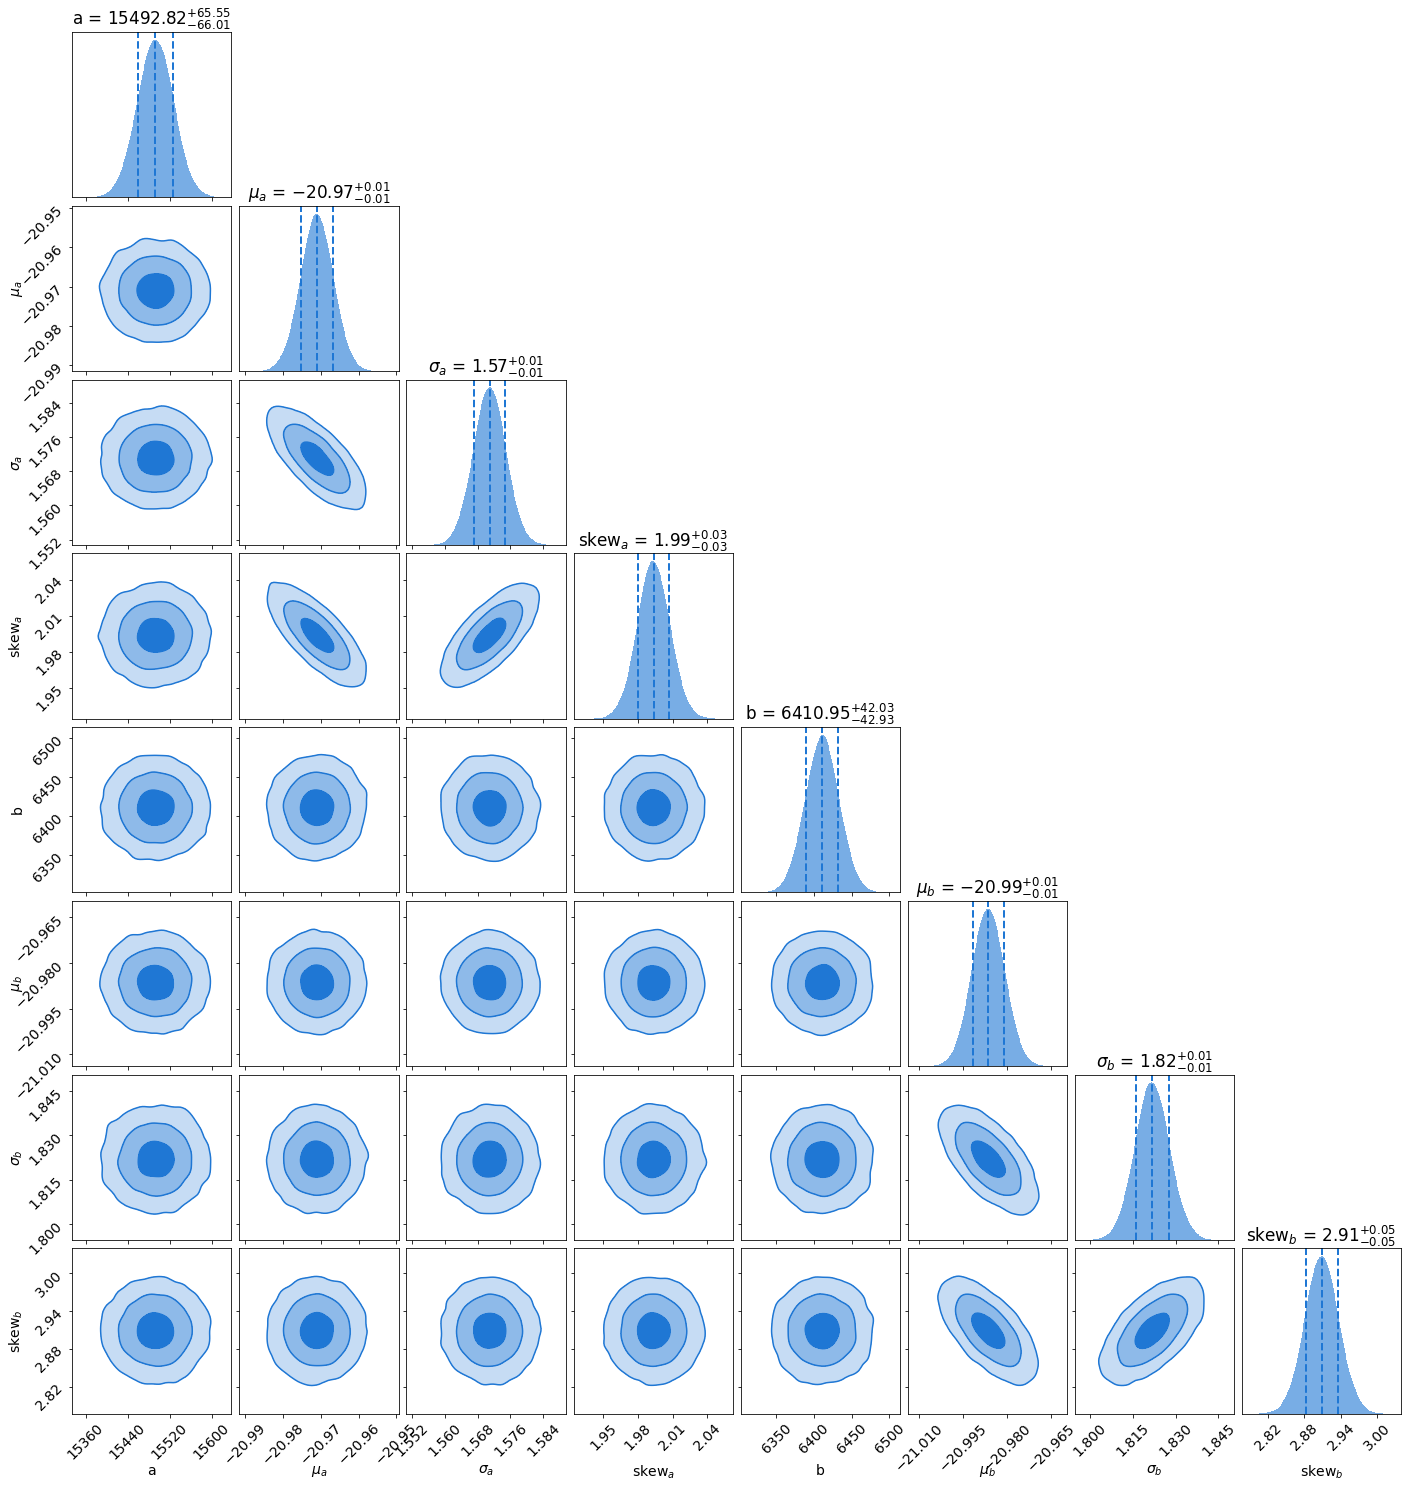

In [65]:
fig, axes = dyplot.cornerplot(dres2_VF_rabsmag, smooth=0.03, 
                              labels=labels2_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

In [66]:
lnzM2_VF_rabsmag = dres2_VF_rabsmag.logz[-1]
lnzM2_VF_rabsmag

-7362.94217585405

## Bayes Factor

In [67]:
lnB12_V2_rabsmag = lnzM1_V2_rabsmag - lnzM2_V2_rabsmag

B12_V2_rabsmag = np.exp(lnB12_V2_rabsmag)

print('V2 Mr: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_rabsmag, np.log10(B12_V2_rabsmag)))

V2 Mr: B12 = 8.4e+04; log(B12) = 4.92


In [68]:
lnB12_VF_rabsmag = lnzM1_VF_rabsmag - lnzM2_VF_rabsmag

B12_VF_rabsmag = np.exp(lnB12_VF_rabsmag)

print('VoidFinder Mr: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_VF_rabsmag, 
                                                              lnB12_VF_rabsmag*np.log10(np.exp(1))))

VoidFinder Mr: B12 = 0; log(B12) = -729.282


So model $\mathcal{M}_1$, in which the two data sets come from the same parent distribution, is overwhelmingly favored by four orders of magnitude for the $V^2$ $M_*$ distribution.

And model $\mathcal{M}_2$, in which the two data sets come from different parent distributions, is overwhelmingly favored by 700 orders of magnitude for the VoidFinder $M_*$ distribution.